In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import norm
from statsmodels.base.model import GenericLikelihoodModel
import seaborn as sns
sns.set_palette("muted")
sns.set_color_codes()
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
sns.set_style({"axes.grid": "True", "grid.color": "0.95"})

plt.rcParams["figure.figsize"] = [6,6]
plt.rcParams["figure.dpi"] = 100

In [2]:
import matplotlib as mpl
def darken_color(color, p):
    return (color[0]*p,color[1]*p,color[2]*p)

colors = sns.color_palette("muted") + [(.1, .1, .1)]
for code, color in zip(["bd","gd","rd","md","yd","cd","kd"], colors):
    rgb = mpl.colors.colorConverter.to_rgb(darken_color(color,0.8))
    mpl.colors.colorConverter.colors[code] = rgb
    mpl.colors.colorConverter.cache[code] = rgb

Prepare variable list for reading the result files. `var_names` need to be changed for time-dependent results.

In [3]:
import os
import glob
var_types = ("gen", "fit", "err")
var_names = ("ap", "apa", "a0", "a0a", "at", "ata")
# var_names = ("ap", "apa", "a0", "a0a", "at", "ata", "xp", "x0", "xt", "yp", "y0", "yt", "xbp", "xb0", "xbt", "ybp", "yb0", "ybt")
vars = ([var_name + "_" + var_type for var_name in var_names for var_type in var_types])

In [4]:
dirs = [
    '../results/cr_ti_eff6_190327',
    '../results/crscf_ti_eff6_190327_scf_190323'
    
]

dfs = []
for directory in dirs:
    all_files = glob.glob(os.path.join(directory, "*.result"))
    print("Num files in '" + str(directory) + "': " + str(len(all_files)))
    df_from_each_file = (pd.read_csv(f, sep=" \|\| | \| | ", header=None, names=vars, engine='python') for f in all_files)
    df = pd.concat(df_from_each_file, ignore_index=True)
    dfs.append(df)

Num files in '../results/cr_ti_eff6_190327': 22
Num files in '../results/crscf_ti_eff6_190327_scf_190323': 22


Calculate the pulls and display their means and then standard deviations.

In [5]:
dfs_pulls = []
for i in range(0, len(dirs)):
    df = dfs[i]
    df_pulls_dict = {var : (df[var + "_fit"] - df[var + "_gen"])/df[var + "_err"] for var in var_names}
    df_pulls = pd.DataFrame(df_pulls_dict)
    dfs_pulls.append(df_pulls)

In [6]:
for var in var_names:
    print("{:4}| ".format(var), end='')
    for i in range(0, len(dirs)):
        print("{:+6.2f} | ".format(dfs_pulls[i].mean()[var]), end='')
    print()

ap  |  +0.26 |  -0.52 | 
apa |  -0.16 |  +0.83 | 
a0  |  +0.01 |  -0.13 | 
a0a |   +nan |   +nan | 
at  |  -0.30 |  +0.77 | 
ata |  -0.15 |  +0.21 | 


In [7]:
for var in var_names:
    print("{:4}| ".format(var), end='')
    for i in range(0, len(dirs)):
        print("{:+5.2f} | ".format(dfs_pulls[i].std()[var]), end='')
    print()

ap  | +0.96 | +1.10 | 
apa | +0.89 | +0.94 | 
a0  | +0.90 | +0.92 | 
a0a |  +nan |  +nan | 
at  | +1.23 | +1.33 | 
ata | +0.87 | +0.92 | 


The following cell shows a distribution of pulls for all directories and all variables

Plots for dir ../results/cr_ti_eff6_190327


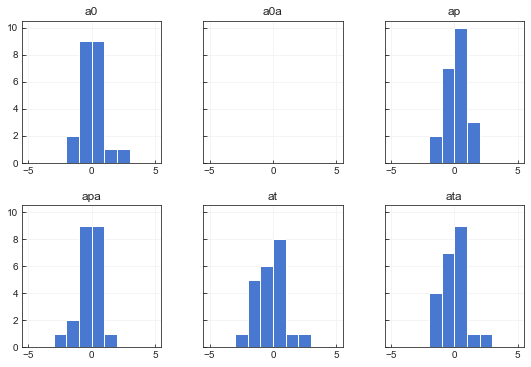

Plots for dir ../results/crscf_ti_eff6_190327_scf_190323


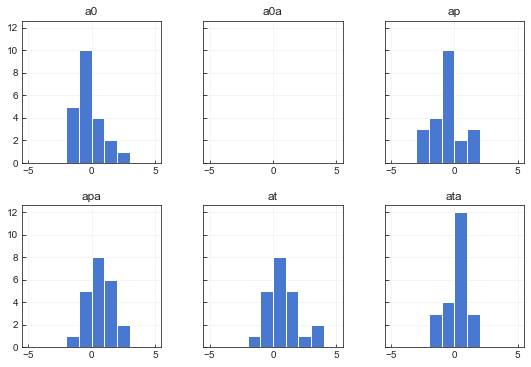

In [8]:
plt.rcParams["figure.figsize"] = [9,6]
# plt.rcParams["figure.figsize"] = [9,18]
for i, dir in enumerate(dirs):
    axs = dfs_pulls[i].hist(column=list(var_names), 
                            sharey=True, layout = (2, 3), range=(-5, 5), bins=10)
#                             sharey=True, layout = (6, 3), range=(-5, 5), bins=10)
    print("Plots for dir " + dir)
    plt.show()

In [9]:
class Gaussian(GenericLikelihoodModel):
    def __init__(self, endog, exog=None, **kwds):
        #if exog is None:
        #    exog = np.zeros_like(endog)
            
        super(Gaussian, self).__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):
        loc = params[0]
        scale = params[1]

        return -np.log(norm.pdf(self.endog, loc=loc, scale=scale))
    
    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        if start_params is None:
            loc_start = self.endog.mean()
            scale_start = self.endog.std()
            
            start_params = np.array([loc_start, scale_start])
            
        return super(Gaussian, self).fit(start_params=start_params,
                                         maxiter=maxiter, maxfun=maxfun, **kwds)

This fits the pull distributions with Gaussians and shows the uncertainties on the $\mu$ and $\sigma$ of each distribution. 

In [10]:
real_vars = list(var_names)
real_vars.remove('a0a')

for i, dir in enumerate(dirs):
    print("Results for dir " + dir)
    for var in real_vars:
        model = Gaussian(dfs_pulls[i][var]);
        results = model.fit(disp=False);
        print("{:4}: ({:+.2f} +- {:.2f}) +- ({:+.2f} +- {:.2f})".format(
            var, results.params[0], results.bse[0], results.params[1], results.bse[1]))
    print()

Results for dir ../results/evtgen_ti
ap  : (+0.52 +- 0.16) +- (+0.80 +- 0.11)
apa : (+0.26 +- 0.19) +- (+0.96 +- 0.14)
a0  : (-0.68 +- 0.18) +- (+0.91 +- 0.13)
at  : (+0.32 +- 0.22) +- (+1.11 +- 0.16)
ata : (-0.12 +- 0.18) +- (+0.89 +- 0.13)

Results for dir ../results/crscf_ti_funcscf
ap  : (+1.45 +- 0.20) +- (+0.88 +- 0.14)
apa : (-4.01 +- 0.14) +- (+0.61 +- 0.10)
a0  : (+0.70 +- 0.22) +- (+0.98 +- 0.15)
at  : (-2.56 +- 0.23) +- (+1.03 +- 0.16)
ata : (-1.97 +- 0.21) +- (+0.92 +- 0.15)

Results for dir ../results/crscf_ti_kdescf
ap  : (-0.17 +- 0.20) +- (+0.90 +- 0.14)
apa : (-2.15 +- 0.14) +- (+0.63 +- 0.10)
a0  : (+2.80 +- 0.22) +- (+1.00 +- 0.16)
at  : (-3.49 +- 0.23) +- (+1.03 +- 0.16)
ata : (-1.70 +- 0.21) +- (+0.95 +- 0.15)



We now calculate the relative errors $|\sigma/\mu|$ for each variable and dataset

In [11]:
# Calculate relative errors
dfs_relative_errors = []
for i in range(0, len(dirs)):
    df = dfs[i]
    df_relative_errors_dict = {var : abs(df[var + "_err"]/df[var + "_fit"]) for var in var_names}
    df_relative_errors = pd.DataFrame(df_relative_errors_dict)
    dfs_relative_errors.append(df_relative_errors)
#df_pulls = df_pulls.drop(list(var_names[0:6]), axis=1)

# Display relative errors in a table
for var in var_names:
    print("{:4}| ".format(var), end='')
    for i, dir in enumerate(dirs):
        print("{:7.2} | ".format(dfs_relative_errors[i].mean()[var]), end='')
    print()

ap  |  0.0095 |  0.0092 |  0.0095 | 
apa |   0.028 |   0.032 |   0.031 | 
a0  | 0.00093 | 0.00091 |  0.0009 | 
a0a |     nan |     nan |     nan | 
at  |   0.015 |   0.015 |   0.016 | 
ata |  0.0046 |  0.0049 |   0.005 | 


This might be useful if we want to plot the fitted Gaussian on top of the histograms.

tau = -0.160 +- 0.868 ps


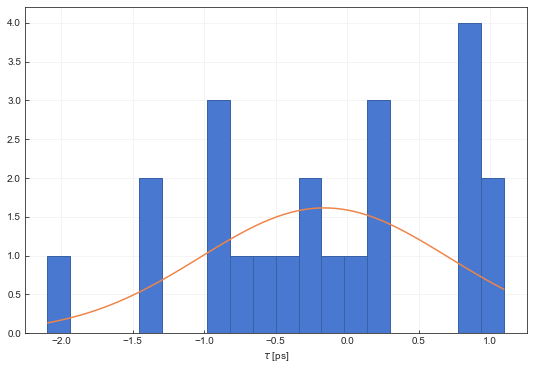

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("$\\tau$ [ps]")
#ax.set_xlim(1.5, 1.57)

data = dfs_pulls[0].apa

# Create histogram and calculate area under it for
# renormalization of fitted PDF
n, bins, patches = plt.hist(data, bins=20, edgecolor=darken_color(sns.color_palette("muted")[0], 0.8))
area = np.sum(np.diff(bins)*n)

mu, sigma = norm.fit(data)

# Create a bunch of equidistant points to calculate the 
# function values at (many points to make it look smooth)
x = np.linspace(data.min(), data.max(), 100)
norm_fitted = norm.pdf(x, mu, sigma)*area
plt.plot(x, norm_fitted)
print("tau = {:.3f} +- {:.3f} ps".format(mu, sigma))